In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import matplotlib as plt
import seaborn as sns
from random import randint, choice
from os import path
from main_data import (
    key_to_camelot,
    add_features,
    get_playlist,
    get_friendly,
    json_to_df,
    add_features,
    sp,
)


In [2]:
# Import DataFrames generated by main_data.py
def import_all():
    (
        all_streams,
        music_streams_no_features,
        music_streams,
        no_skip_df,
        playlist_example,
        podcasts,
        wheel_df,
    ) = json_to_df(
        "all_streams.json",
        "music_streams_no_features.json",
        "music_streams.json",
        "no_skip_df.json",
        "playlist_example.json",
        "podcasts.json",
        "wheel_df.json",
    )
    return (
        all_streams,
        music_streams_no_features,
        music_streams,
        no_skip_df,
        playlist_example,
        podcasts,
        wheel_df,
    )


# todo: move to main


def hpm(df, average=None):
    # df["month"] = df.copy().timestamp.dt.month
    df_groupby = (
        df.sort_values(by="month")
        .groupby(["month", pd.Grouper(key="timestamp", freq="Y")])["playtime_h"]
        .sum()
        .groupby("month")
    )
    return df_groupby.mean().sort_index() if average else df_groupby.sum().sort_index()


def plothpm(df_gb):
    df_gb.index = pd.PeriodIndex(df_gb.index, freq="M")
    df_gb = df_gb.sort_index()
    df_gb.index = df_gb.index.strftime("%b")
    # df_gb.index = df_gb.rename(lambda x: x.strftime("%b"))
    return sns.barplot(data=df_gb.iloc[0:0], x=df_gb.index, y=df_gb.values)


def del_skips(deef):
    return deef.query("(playtime_s / duration) > 0.75").reset_index()


def most_played(df, years=False, noskips=False, artists=False, nofeatures=False):
    cols = ["artist", "track", "year"]
    if noskips:
        df = del_skips(df)
    if not years:
        years = df.timestamp.dt.year.unique()
        cols.remove("year")
    if artists:
        cols.remove("track")
    return (
        pd.DataFrame(
            df.query("timestamp.dt.year in @years")
            .pivot_table(columns=cols, aggfunc="size")
            .sort_values(ascending=False)
        )
        .reset_index()
        .rename(columns={0: "count"})
    )


def format_td(td):
    """Converts timedelta to hh:mm:ss strictly for presentation purposes"""
    minutes, seconds = divmod(td.seconds + td.days * 86400, 60)
    hours, minutes = divmod(minutes, 60)
    return "{:d}:{:02d}:{:02d}".format(hours, minutes, seconds, td.microseconds)


def randyear(df):
    return choice(range(df.timestamp.dt.year.min(), df.timestamp.dt.year.max() + 1))


In [3]:
(
    all_streams,
    music_streams_no_features,
    music_streams,
    no_skip_df,
    playlist_example,
    podcasts,
    wheel_df,
) = import_all()


In [12]:
podcasts.dtypes

timestamp     float64
playtime_s    float64
track         float64
artist        float64
id            float64
playtime_m    float64
playtime_h    float64
date          float64
month         float64
year          float64
day           float64
dtype: object

In [14]:
most_played(music_streams_no_features.drop_duplicates(subset="track"), artists=True).head(5)


,artist,count
0,MF DOOM,157
1,Ludwig van Beethoven,152
2,Miles Davis,144
3,Aphex Twin,117
4,The Roots,115


<AxesSubplot: xlabel='month'>

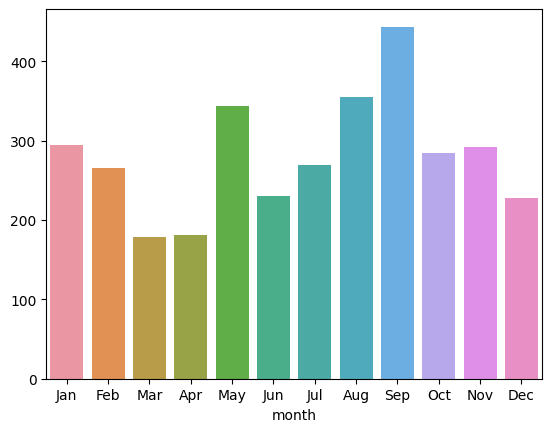

In [6]:
plothpm(hpm(all_streams))


In [ ]:
music_streams_no_features.loc[:, ["playtime_h", "timestamp"]].groupby(
    by=music_streams_no_features.timestamp.dt.tz_localize("UTC")
    .dt.tz_convert("EST")
    .dt.hour
).sum(numeric_only=True).sort_values(by="playtime_h", ascending=False)


,playtime_h
timestamp,
0,216.43
1,211.63
2,198.57
23,194.39
4,176.43
22,175.53
21,173.14
3,171.39
5,160.46


In [ ]:
music_streams


,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
0,Rich Boy,Throw Some D's Remix,Rich Boy,351,5.85,2021-03-25,Thu,Mar,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-03-25 18:43:26,351,0.10
1,Rich Boy,Throw Some D's Remix,Rich Boy,351,2.60,2021-08-07,Sat,Aug,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-08-07 05:06:29,156,0.04
2,Rich Boy,Throw Some D's Remix,Rich Boy,351,5.85,2021-01-21,Thu,Jan,2021,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2021-01-21 05:42:09,351,0.10
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,0.00,2019-10-18,Fri,Oct,2019,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2019-10-18 18:04:48,0,0.00
4,Rich Boy,Throw Some D's Remix,Rich Boy,351,0.03,2022-02-17,Thu,Feb,2022,161,12A,D-flat minor,True,1qXLj4ywjsA0hGmaibmnn3,2022-02-17 11:15:58,2,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85407,James Blake,Frozen (feat. JID & SwaVay),Friends That Break Your Heart,236,3.93,2022-09-29,Thu,Sep,2022,100,6B,B-flat major,False,4IX1G5Ibs3aWyiSLUO7OPt,2022-09-30 03:19:58,236,0.07
85408,Teitanblood,Anteinfierno,Death,297,4.95,2021-09-24,Fri,Sep,2021,101,6A,G minor,False,2uFlPURngrcfsOz1nHgpaO,2021-09-25 04:34:37,297,0.08
85409,Xenia Rubinos,How Strange It Is,Black Terry Cat,192,3.20,2019-12-05,Thu,Dec,2019,112,11B,A major,False,0ta023auUvOMAhzQ4oIRF9,2019-12-06 04:52:04,192,0.05
85410,Master P,Meal Ticket,I'm Bout It,244,4.07,2021-01-18,Mon,Jan,2021,152,10B,D major,False,5TIGd8F70sI5mk6U4bubX8,2021-01-19 01:55:48,244,0.07


In [ ]:
music_streams.sort_values(by="playtime_s")


,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
47809,Ludwig van Beethoven,"Piano Sonata No. 11 In B Flat Major, Op. 22: 4...",Beethoven: The Piano Sonatas,371,0.00,2020-04-04,Sat,Apr,2020,131,6B,B-flat major,False,4W1CenpP9ZxvSwhRHkgVF6,2020-04-04 14:15:08,0,0.00
3782,Main Source,Just a Friendly Game of Baseball - 2017 Remast...,Breaking Atoms,202,0.00,2021-05-07,Fri,May,2021,94,11A,F-sharp minor,False,3gI4WHUyXCP96IQb9hzxnJ,2021-05-07 14:13:54,0,0.00
16421,Aphex Twin,Nanou2,Drukqs,205,0.00,2020-01-04,Sat,Jan,2020,93,4B,A-flat major,False,6Wei2NUSG66WzLiqSuQAy5,2020-01-04 05:15:09,0,0.00
82851,Sasha Carassi,Nomads,Kill The Monster EP,416,0.00,2022-04-15,Fri,Apr,2022,122,12A,D-flat minor,False,6z8CNKl6hK2yAvqnUXZeoU,2022-04-15 10:01:06,0,0.00
69678,Y1640,Spit Intent,Spit Intent,259,0.00,2020-04-04,Sat,Apr,2020,150,8B,C major,False,0id4Rkg8xaN68PKcIHCfAp,2020-04-04 17:47:22,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82774,William Basinski,El Camino Real,El Camino Real,3000,50.00,2021-01-28,Thu,Jan,2021,142,3B,D-flat major,False,5owloXCqdMDgyXfLXrdpAc,2021-01-28 12:50:11,3000,0.83
64071,William Basinski,dlp 5,The Disintegration Loops III,3141,52.35,2021-02-02,Tue,Feb,2021,135,7B,F major,False,36XtPJCvIs7ucoMDMIBRI7,2021-02-02 08:55:46,3141,0.87
67998,William Basinski,dlp 1.1,The Disintegration Loops,3816,63.60,2022-07-26,Tue,Jul,2022,95,7B,F major,False,10SeyQmuBIVJmbZYYJs07W,2022-07-26 10:01:01,3816,1.06
70705,William Basinski,dlp 1.1,The Disintegration Loops,3816,63.60,2021-01-28,Thu,Jan,2021,95,7B,F major,False,31FiS1jMI38kYfC8ey358W,2021-01-28 09:30:35,3816,1.06


In [ ]:
# Most played songs 2022
most_played(music_streams, noskips=True, years=[2022])


,artist,track,year,count
0,Rvdical the Kid,Nasa,2022,23
1,Pusha T,Brambleton,2022,23
2,Lava La Rue,G.O.Y.D.,2022,22
3,Lava La Rue,Cry Baby,2022,17
4,Billy Lemos,Midlife Crisis,2022,17
...,...,...,...,...
6275,Leikeli47,CIAA,2022,1
6276,Leikeli47,Carry Anne,2022,1
6277,Leikeli47,Done Right,2022,1
6278,Leikeli47,Free To Love,2022,1


In [ ]:
# Top 30 most played tracks 
most_played(music_streams_no_features).head(30)

,artist,track,count
0,Teebs,Black Dove,124
1,Hope Tala,Moontime,108
2,Andy Stott,New Romantic,100
3,Dope Saint Jude,Grrrl Like,97
4,Aphex Twin,Alberto Balsalm,94
5,Teebs,Studie,92
6,SUPEREGO,O.B.S (Outer Body Stranger) [feat. Sampa the G...,90
7,Low Leaf,Go Go Go,83
8,Nappy Nina,Treehouse,79
9,DjRUM,"Showreel, Pt. 3",76


In [ ]:
# Most listened to artists by number of songs played
most_played(music_streams, noskips=True)

,artist,track,count
0,myNoise,Stereo Left-Right (Test Only),118
1,Teebs,Black Dove,100
2,Hope Tala,Moontime,89
3,Teebs,Studie,76
4,Aphex Twin,Alberto Balsalm,65
...,...,...,...
18693,Derrick Harriott,I Don't Want to Cry,1
18694,Derrick Harriott,Have You Seen Her,1
18695,Machinefabriek,Zucht 2,1
18696,Mackk,Forever - Cleo Reed Remix,1


In [ ]:
miles = no_skip_df.query('artist.str.contains("(?i)Miles Davis")')
pivot_miles = pd.pivot_table(miles, values="playtime_s", index=["album"], aggfunc="sum")
pivot_miles = pivot_miles.sort_values(by="playtime_s", ascending=False)
miles


,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
697,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.50,2019-09-30,Mon,Sep,2019,119,9B,G major,False,1q2Jzd23O49Crk91Rijl7Y,2019-09-30 21:57:11,450,0.12
698,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.48,2022-05-28,Sat,May,2022,119,9B,G major,True,1q2Jzd23O49Crk91Rijl7Y,2022-05-28 12:32:59,449,0.12
699,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.50,2021-09-05,Sun,Sep,2021,119,9B,G major,True,1q2Jzd23O49Crk91Rijl7Y,2021-09-05 08:45:02,450,0.12
700,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.50,2021-05-28,Fri,May,2021,119,9B,G major,False,1q2Jzd23O49Crk91Rijl7Y,2021-05-29 00:22:10,450,0.12
701,Miles Davis,Maiysha (So Long) (feat. Erykah Badu),Everything's Beautiful,450,7.50,2021-07-16,Fri,Jul,2021,119,9B,G major,False,1q2Jzd23O49Crk91Rijl7Y,2021-07-17 01:09:49,450,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47412,Miles Davis,Summertime - Mono Version,Porgy and Bess (Mono Version),199,3.32,2022-02-20,Sun,Feb,2022,106,4A,F minor,False,0YRlrc4JzUCXHLS2j5keej,2022-02-21 03:14:35,199,0.06
47558,Miles Davis,Go Ahead John - part two C,Miles Ahead (Original Motion Picture Soundtrack),220,3.67,2019-11-24,Sun,Nov,2019,122,3B,D-flat major,False,12hZQoeLnufiPI7l1CYfHn,2019-11-25 01:48:15,220,0.06
47593,Miles Davis,"Billy Boy (feat. John Coltrane, Cannonball Add...",Milestones (Mono),435,7.25,2022-02-21,Mon,Feb,2022,134,8B,C major,False,5Jm4C3t6fn5WuRZQcjwvqx,2022-02-21 23:36:48,435,0.12
47602,Miles Davis,"So Near, So Far",Seven Steps To Heaven,417,6.95,2020-01-24,Fri,Jan,2020,84,9B,G major,False,0CpyNb2RlzO7345kFiwXzg,2020-01-25 04:56:07,417,0.12


In [ ]:
pivot_album_time = pd.pivot_table(
    no_skip_df, values="playtime_s", index=["album"], aggfunc="sum"
)


In [ ]:
pivot_album_time = pivot_album_time.sort_values(by="playtime_s", ascending=False)
pivot_album_time.head(20)


,playtime_s
album,
Anicca,78788
Blonde,63915
MAGDALENE,63106
When I Get Home,61274
Radio Amor,59900
Portrait with Firewood,52849
Couldn't Wait to Tell You...,51087
Take Me Apart,48455
It Should Be Us,40426


In [ ]:
pivot_artist_time = pd.pivot_table(
    no_skip_df, values="playtime_h", index=["artist"], aggfunc="sum"
)


In [ ]:
# print(pivot_artist_time.sort_values().to_string())
artist_time = pivot_artist_time.sort_values(
    by="playtime_h", ascending=False
).reset_index()
print(artist_time.to_string())


                                           artist  playtime_h
0                                      Tim Hecker       38.10
1                                      Andy Stott       37.01
2                                      Aphex Twin       34.42
3                                           Teebs       30.38
4                                     Frank Ocean       30.28
5                                         Solange       28.83
6                                           DjRUM       24.71
7                                          Noname       23.44
8                            Ludwig van Beethoven       22.83
9                                     Miles Davis       21.48
10                                      Hope Tala       20.69
11                                          Smino       20.60
12                                         Kelela       19.89
13                                      FKA twigs       18.83
14                                    Erykah Badu       17.47
15      

In [ ]:
# Artists played more than 10 mins
repeated_artists = artist_time[:1750]
# Number of unique tracks played from those artists

len(music_streams["track"].unique())


27651

In [ ]:
still_repeated = repeated_artists["artist"]


In [ ]:
# Count number of unique tracks per artist and create ascending list
still_still_repeated = no_skip_df.query("artist in @still_repeated")
# still_still_repeated.loc[:, 'artist'] = still_still_repeated.copy().loc[:, 'artist'].astype(str)
group = still_still_repeated.groupby("artist")
songs_per_artist = group.apply(lambda x: x["track"].unique())
unique_songs = songs_per_artist.reset_index(name="unique_titles")


In [ ]:
unique_songs["unique_count"] = unique_songs.iloc[:, 1].str.len()


In [ ]:
unique_songs = unique_songs.sort_values(by="unique_count").reset_index()


In [ ]:
unique_export = unique_songs.query("unique_count <= 8")["artist"]


In [ ]:
pivot_artist_time.playtime_h


artist
 Sentinel                    0.47
"Weird Al" Yankovic          0.06
$ilkMoney                    0.26
$oudière                     0.06
$uicideboy$                  0.08
                             ... 
△▃△▓                         0.04
⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ    0.56
セキトオ・シゲオ                     0.30
チェスマスター                      0.27
박혜진 Park Hye Jin             1.03
Name: playtime_h, Length: 4193, dtype: float64

In [ ]:
# Artists with 10 or less songs played that I've heard more than an hour of. Indicative of artists I should seek more songs from, and/or artists with very long average song lengths.
pivot_artist_time.query("playtime_h > 1").query("artist in @unique_export").sort_values(
    by="playtime_h", ascending=False
).head(50)


,playtime_h
artist,
Fela Kuti,3.97
Jojo Abot,3.54
Dope Saint Jude,3.34
SUPEREGO,3.32
Source Direct,3.21
King Geedorah,3.14
Leyya,3.11
Boney M.,2.83
Mustard,2.70


In [ ]:
# Show longest songs
no_skip_df.sort_values(by="playtime_s", axis=0, ascending=False)


,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
43832,William Basinski,Watermusic II,Watermusic II,3998,66.63,2021-01-28,Thu,Jan,2021,71,7B,F major,False,1IERjUpo0AhB3yoxCBl7FQ,2021-01-28 11:04:11,3998,1.11
38806,William Basinski,dlp 1.1,The Disintegration Loops,3816,63.60,2022-07-26,Tue,Jul,2022,95,7B,F major,False,10SeyQmuBIVJmbZYYJs07W,2022-07-26 10:01:01,3816,1.06
40251,William Basinski,dlp 1.1,The Disintegration Loops,3816,63.60,2021-01-28,Thu,Jan,2021,95,7B,F major,False,31FiS1jMI38kYfC8ey358W,2021-01-28 09:30:35,3816,1.06
36625,William Basinski,dlp 5,The Disintegration Loops III,3141,52.35,2021-02-02,Tue,Feb,2021,135,7B,F major,False,36XtPJCvIs7ucoMDMIBRI7,2021-02-02 08:55:46,3141,0.87
46564,William Basinski,El Camino Real,El Camino Real,3000,50.00,2021-01-28,Thu,Jan,2021,142,3B,D-flat major,False,5owloXCqdMDgyXfLXrdpAc,2021-01-28 12:50:11,3000,0.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7376,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,0.05,2021-02-20,Sat,Feb,2021,0,12B,E major,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:26:15,3,0.00
7461,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,0.05,2021-02-20,Sat,Feb,2021,0,12B,E major,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:28:10,3,0.00
7375,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,0.05,2021-02-20,Sat,Feb,2021,0,12B,E major,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:27:03,3,0.00
7462,myNoise,Stereo Left-Right (Test Only),The Ultimate Headphone Test (Original Audioche...,3,0.05,2021-02-20,Sat,Feb,2021,0,12B,E major,False,03WtqbdM2RSGzskN8ozKWB,2021-02-21 02:24:12,3,0.00


In [ ]:
music_streams.query("year == 2019")


,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
3,Rich Boy,Throw Some D's Remix,Rich Boy,351,0.00,2019-10-18,Fri,Oct,2019,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2019-10-18 18:04:48,0,0.00
13,Rich Boy,Throw Some D's Remix,Rich Boy,351,2.62,2019-08-08,Thu,Aug,2019,161,12A,D-flat minor,False,1qXLj4ywjsA0hGmaibmnn3,2019-08-08 20:44:44,157,0.04
18,Latto,Bounce,Big Latto,158,2.63,2019-12-05,Thu,Dec,2019,143,5A,C minor,False,45anQ4WSf2a9QhZq55aaMw,2019-12-05 05:13:00,158,0.04
19,Latto,Bounce,Big Latto,158,2.63,2019-12-09,Mon,Dec,2019,143,5A,C minor,False,45anQ4WSf2a9QhZq55aaMw,2019-12-09 08:24:53,158,0.04
20,Young Gunz,"Can't Stop, Won't Stop",Tough Luv,263,4.38,2019-12-07,Sat,Dec,2019,100,11A,F-sharp minor,False,1kgDlypHy9hCvCxeoCtd7X,2019-12-07 08:21:03,263,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85354,Don Drummond,Alipanga,Ska Kings of the First Wave with the Skatalite...,185,3.08,2019-09-26,Thu,Sep,2019,128,10B,D major,False,12h2FUNq9ZohvTHxzPPpf7,2019-09-26 18:43:09,185,0.05
85367,Tei Shi,Even If It Hurts (feat. Blood Orange),Even If It Hurts (feat. Blood Orange),251,0.00,2019-10-05,Sat,Oct,2019,192,10A,B minor,False,78QxYtMmjRePQ4KAe0cZFa,2019-10-06 03:22:52,0,0.00
85385,Misfits,Helena,Famous Monsters,200,0.07,2019-11-22,Fri,Nov,2019,147,6B,B-flat major,False,3cpZPDaWYxxy0Ho2uIyYRW,2019-11-23 01:13:44,4,0.00
85393,Rayana Jay,Sleepy Brown,Sorry About Last Night,240,4.00,2019-12-24,Tue,Dec,2019,87,8A,A minor,False,0oblE8jy4Yj8K8Cdsqo70S,2019-12-24 12:44:03,240,0.07


<AxesSubplot: ylabel='playtime_h'>

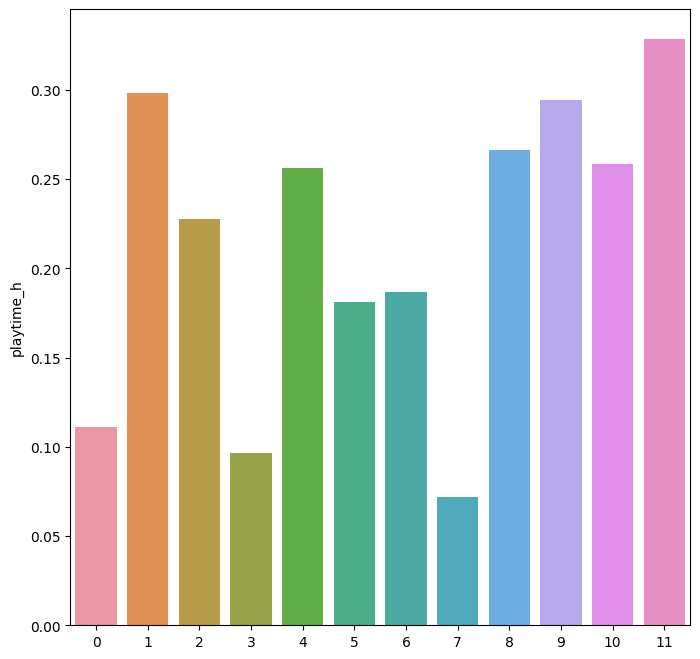

In [ ]:
# How to control this for missing months? do october 25 2019 thru 2022
plt.rcParams["figure.figsize"] = (8, 8)
sns_prep = music_streams.query("year == 2019| year == 2020 | year == 2021")
sns_prep = pd.pivot_table(
    sns_prep,
    values="playtime_s",
    index=sns_prep.timestamp.dt.strftime("%b"),
    aggfunc="sum",
).reset_index()
sns_prep["playtime_h"] = sns_prep["playtime_s"].apply(lambda x: x / 3600000)
sns.barplot(data=sns_prep, x=sns_prep.index, y="playtime_h")


<AxesSubplot: xlabel='month', ylabel='count'>

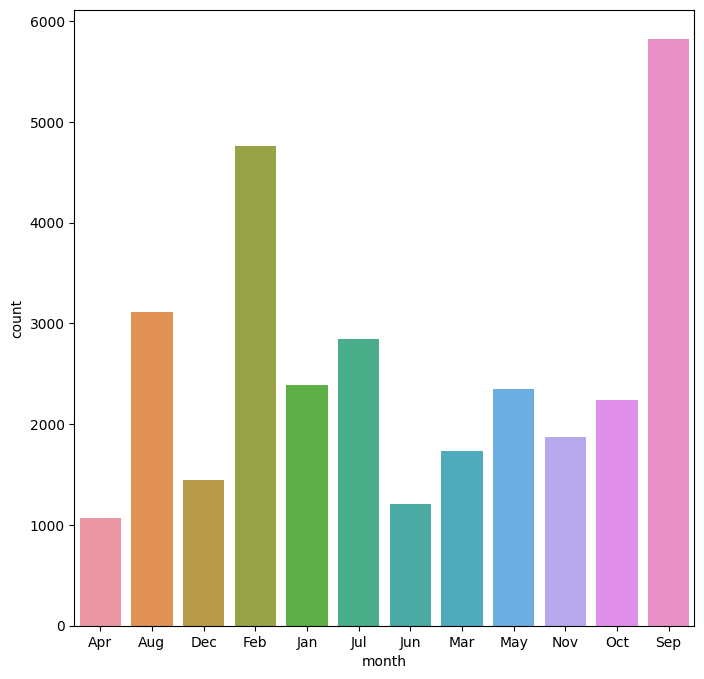

In [ ]:
# sum of unique uris closely maps to total skips per month
sns_prep = music_streams.copy().drop_duplicates(subset="id")
sns_prep["count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


<AxesSubplot: xlabel='month', ylabel='count'>

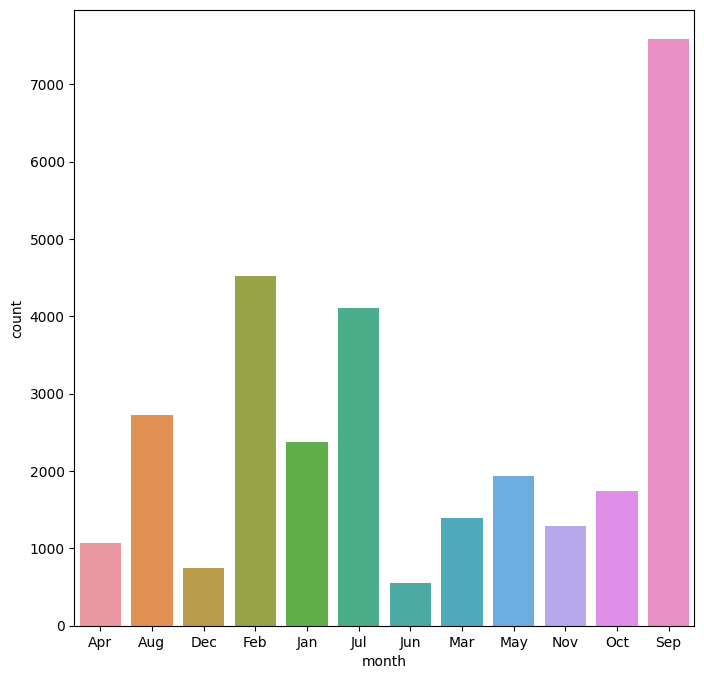

In [ ]:
# good way to find months with most music discovery along with unique URIs
sns_prep = music_streams.copy().query("(playtime_s / duration) < 0.25")
sns_prep.at[:, "count"] = 1
sns_prep = (
    sns_prep.loc[:, ["month", "duration", "playtime_s", "shuffle", "count"]]
    .groupby(by="month")
    .sum(numeric_only=True)
)
sns.barplot(data=sns_prep, x=sns_prep.index, y="count")


In [ ]:
# common keys of listened tracks
no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"]
pivot_track = pd.DataFrame(
    no_skip_df.drop_duplicates(subset="timestamp")
    .pivot_table(columns=["key_signature"], aggfunc="size")
    .sort_values(ascending=False)
)
pivot_track


/tmp/ipykernel_24735/2723578311.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  no_skip_df.loc[:, "timestamp"] = no_skip_df.loc[:, "timestamp"]


,0
key_signature,
D-flat major,5440
G major,3363
C major,3311
B-flat minor,2851
D major,2742
B minor,2365
F minor,2270
A-flat major,2264
E minor,2104


In [ ]:
# # This version works with uri
# #should also have function to get uri from song title + artist
# #todo: proper type hinting and default values
# # separate functions i suppose, maybe with decorators
# # https://stackoverflow.com/questions/62153371/best-way-to-create-python-function-with-multiple-options


get_friendly(
    music_streams, tempo_range=10, uri="5jh3f8fy8a335XYDyJ7x9R", shift=["all"]
).sort_values(by="track")


,index,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
16630,66724,Aphex Twin,#13,Selected Ambient Works Volume II,440,7.33,2020-08-12,Wed,Aug,2020,135,4A,F minor,False,7c4lnS1bSj4fRJWAQ8D54R,2020-08-12 09:42:43,440,0.12
2506,20154,Aphex Twin,#24,Selected Ambient Works Volume II,342,5.70,2019-12-27,Fri,Dec,2019,138,3B,D-flat major,False,0gZzXPfSknP68aZ5sfyVUH,2019-12-28 02:03:14,342,0.10
30158,84725,Thelonious Monk,'Round Midnight,The Complete Blue Note Recordings,192,3.20,2019-11-25,Mon,Nov,2019,119,4A,F minor,False,5fMZdrFptNIunq8QvofowF,2019-11-25 10:59:07,192,0.05
26448,80680,Rare Silk,'Round Midnight,American Eyes,145,0.20,2021-09-04,Sat,Sep,2021,126,2A,E-flat minor,False,363Z97AXyErxvgowae8qB5,2021-09-04 06:02:12,12,0.00
7705,44838,Thelonious Monk Quartet,'Round Midnight,Misterioso [Original Jazz Classics Remasters],378,2.88,2022-02-18,Fri,Feb,2022,136,2A,E-flat minor,False,5wBkOjOd8mpN8NVSCt155l,2022-02-18 10:28:52,173,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,18568,betcover!!,二限の窓,時間,253,4.22,2021-10-28,Thu,Oct,2021,122,3A,B-flat minor,False,38nSGcLUTfu3cH0zu6F2jL,2021-10-28 20:09:11,253,0.07
10912,54273,Tzusing,日出東方 唯我不敗,東方不敗,312,1.08,2021-09-13,Mon,Sep,2021,120,2B,F-sharp major,False,7A1d0qBQL2IiDhrDrhUqE8,2021-09-13 06:07:05,65,0.02
23890,77580,DJ Trystero,水害,High Speed Wind,376,6.27,2022-07-09,Sat,Jul,2022,120,3B,D-flat major,False,27F1Yx7hW1Oez3wc67l9TI,2022-07-10 00:48:51,376,0.10
11337,55377,DJ Trystero,酒気,High Speed Wind,257,4.28,2022-07-09,Sat,Jul,2022,120,3B,D-flat major,False,5HjXB5FtiFZYxXJxCqMjIF,2022-07-10 01:03:42,257,0.07


In [ ]:
# How often do I play songs with "birthday" in the name on my loved ones' birthdays?
music_streams.query("(playtime_s / duration) > 0.1").query(
    "track.str.contains('(?i)birthday')"
).sort_values(by=["month", "date"])


,artist,track,album,duration,playtime_m,date,day,month,year,tempo,camelot,key_signature,shuffle,id,timestamp,playtime_s,playtime_h
76670,2 Chainz,Birthday Song,Based On A T.R.U. Story,307,4.93,2022-04-17,Sun,Apr,2022,140,3B,D-flat major,False,5qkWTBmDmZjogwIvbKtJQv,2022-04-17 10:53:28,296,0.08
12012,Trap Beckham,Birthday Bitch,Birthday Bitch,197,1.03,2021-08-13,Fri,Aug,2021,102,8B,C major,False,4ZFtNZuzzdHjYKARA8TEh2,2021-08-13 08:02:48,62,0.02
19369,Disclosure,Birthday,Birthday,220,2.02,2021-08-13,Fri,Aug,2021,136,4A,F minor,False,2jCSd2lOtWQKtwb7FdfvPQ,2021-08-13 08:07:33,121,0.03
29936,Happy Birthday,Happy Birthday Reggae,10 Happy Birthday Different Styles,98,0.48,2021-08-13,Fri,Aug,2021,110,6B,B-flat major,False,6ZEdAuCh2shaf3E3rrtHAp,2021-08-13 08:18:19,29,0.01
32918,Happy Birthday,Happy Birthday Funk,10 Happy Birthday Different Styles,82,0.85,2021-08-13,Fri,Aug,2021,100,7B,F major,True,2ShnbhqZMChTitBB2AQrVO,2021-08-13 08:20:25,51,0.01
60071,Happy Birthday,Happy Birthday Jazz,10 Happy Birthday Different Styles,110,0.38,2021-08-13,Fri,Aug,2021,120,7B,F major,True,4GeaHbsPgGR1xMPynrPvy5,2021-08-13 08:20:51,23,0.01
61743,Happy Birthday,Happy Birthday Country,10 Happy Birthday Different Styles,57,0.65,2021-08-13,Fri,Aug,2021,78,8B,C major,True,23X23yCXz1mjeDuRJPfTWm,2021-08-13 08:24:08,39,0.01
62631,Migos,Birthday,Culture III,227,0.45,2021-08-13,Fri,Aug,2021,170,5A,C minor,False,7tt5I7ztXfKzZRqyL2FCYb,2021-08-13 08:11:06,27,0.01
67625,Happy Birthday,Happy Birthday EDM,10 Happy Birthday Different Styles,65,0.88,2021-08-13,Fri,Aug,2021,130,11B,A major,False,4iP9axs07uXTxJiAr1l1rX,2021-08-13 08:17:48,53,0.01
69335,Twista,Birthday,Category F5,221,0.90,2021-08-13,Fri,Aug,2021,110,3A,B-flat minor,False,1tXZ25p92QkW2Oj7ElF4pA,2021-08-13 08:16:30,54,0.02


<AxesSubplot: xlabel='month'>

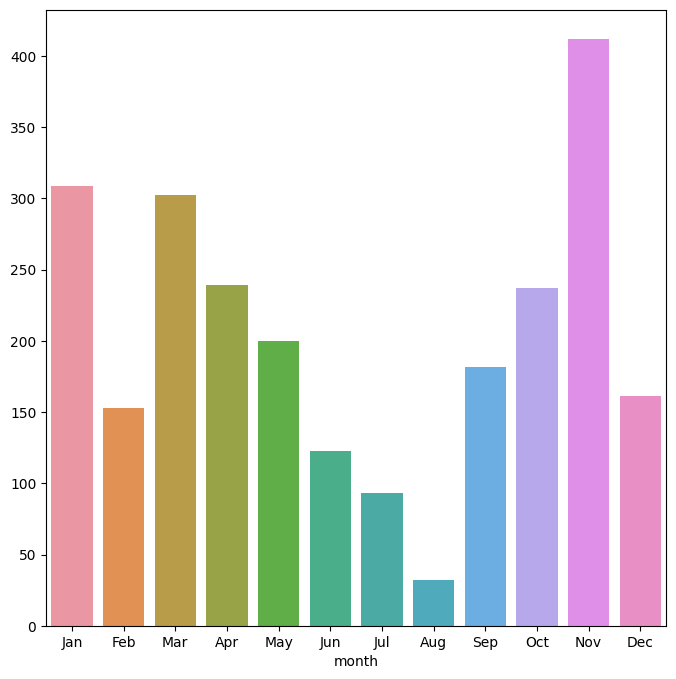

In [ ]:
plothpm(hpm(podcasts))


<AxesSubplot: xlabel='month'>

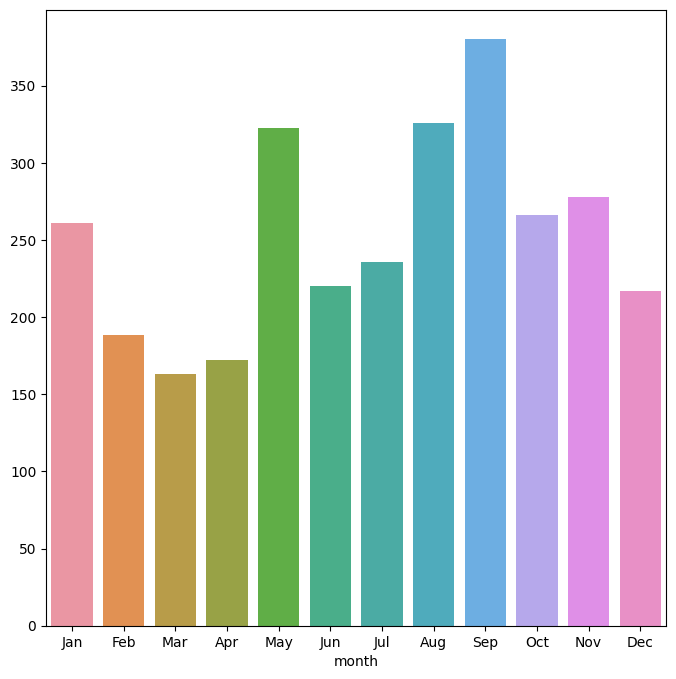

In [ ]:
# Todo: plot podcast listening vs music listening
# damn i really spent most of january 2022 listening to podcats

plothpm(hpm(no_skip_df))
